In [2]:
# Model yoinked from https://github.com/spro/char-rnn.pytorch

import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os

from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#HELPER FUNCTIONS
import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [4]:
#Create model class
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [5]:
filename = "shakespear.txt"
file, file_len = read_file(filename)
lr = 0.01
hidden_size = 100
n_layers = 2
chunk_len = 200
batch_size = 100
epochs = 2000


In [6]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    inp.to(device)
    target.to(device)
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    decoder.to(device)
    hidden.to(device)
    inp.to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c].to(device), hidden.to(device))
        loss += criterion(output.view(batch_size, -1).to(device), target[:,c].to(device))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)


In [7]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    
    hidden.to(device)
    prime_input.to(device)
    decoder.to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p].to(device), hidden.to(device))
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp.to(device), hidden.to(device))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        inp.to(device)

    return predicted


In [8]:
decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

decoder.to(device)

start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % epochs)
    for epoch in tqdm(range(1, epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        all_losses.append(loss)
        
        if epoch % 100 == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / epochs * 100, loss))
            print(generate(decoder.to(device), 'Wh', 100), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()

Training for 2000 epochs...


  5%|▌         | 100/2000 [00:30<10:02,  3.16it/s]

 30s (100 5%) 1.7257]
Which ardnest and and that her with of and the lisless to all the mand's good buty and sir,
You somans 



 10%|█         | 200/2000 [01:00<09:52,  3.04it/s]

 0s (200 10%) 1.6021]
Why dike an I them of the
match the true enougne; bid the maid.

ROMEO:
And thee my might a tongue, my 



 15%|█▌        | 300/2000 [01:30<08:59,  3.15it/s]

 30s (300 15%) 1.5124]
Where the love with himself's-ours!

KING EDWARD IV:

Lord:
A po have head of fie.

PRINCE EDWARD:
Not 



 20%|██        | 400/2000 [01:59<08:08,  3.27it/s]

 59s (400 20%) 1.4459]
Which a lips of them and recovere?

MARCIUS:
Why, the gracious speak, and gentlecion and the sing,
You 



 25%|██▌       | 500/2000 [02:29<07:53,  3.17it/s]

 29s (500 25%) 1.4541]
Where we do gundst not to the findly you have send the day,
And that sorrow yet better he will cram:
W 



 30%|███       | 600/2000 [02:59<07:15,  3.22it/s]

 59s (600 30%) 1.4331]
What is not present to our trust on his Lady:
That I say you on them to the stobence with her,
And we  



 35%|███▌      | 700/2000 [03:29<06:24,  3.38it/s]

 29s (700 35%) 1.4330]
What's a death all sildity with
it to the white to summied how too that I would.
Then, my lord's broth 



 40%|████      | 800/2000 [03:57<05:58,  3.35it/s]

 57s (800 40%) 1.4010]
Whear, never presant; and she professor with and First his way or
sirrings of battle daughter,
I charr 



 45%|████▌     | 900/2000 [04:26<05:21,  3.42it/s]

 26s (900 45%) 1.4006]
Whe did for prove answer us can she request
When it it fault, quiet my brother Aufidius,
You will you  



 50%|█████     | 1000/2000 [04:55<05:07,  3.25it/s]

 55s (1000 50%) 1.3955]
Whou wert thou did bid his life:
What my lorders deyer her would revil the horse when
sups for thee, i 



 55%|█████▌    | 1100/2000 [05:24<04:25,  3.39it/s]

 24s (1100 55%) 1.3738]
Which he could?

ESCALUS:
Why, one is such him father.

MENENIUS:
The flatter, coverful noble friared  



 60%|██████    | 1200/2000 [05:53<04:04,  3.28it/s]

 53s (1200 60%) 1.3779]
Whapon from hold the Lord Warwick,
Shook at nine Master the bid him convey:
Who was that is partunes t 



 65%|██████▌   | 1300/2000 [06:22<03:33,  3.28it/s]

 22s (1300 65%) 1.3752]
What wonder than I prepared
This far with mode, let the thought to a bawd.
Come, the boy is war and ha 



 70%|███████   | 1400/2000 [06:51<03:01,  3.30it/s]

 51s (1400 70%) 1.3528]
Which scrath our love was? had you unknown these
here is the death hates to be have done?

DUKE OF YOR 



 75%|███████▌  | 1500/2000 [07:20<02:38,  3.16it/s]

 20s (1500 75%) 1.3446]
While, magness you?

ISABELLA:

GLOUCESTER:
My lord Mawars is made his return, he and ewel,
Which thou 



 80%|████████  | 1600/2000 [07:49<02:03,  3.24it/s]

 49s (1600 80%) 1.3178]
Which battle and that to hear, give you.

ROMEO:
The despair?

POLIXENES:
Come, and to what know, peat 



 85%|████████▌ | 1700/2000 [08:17<01:31,  3.28it/s]

 17s (1700 85%) 1.3536]
What shall appeal common'd that begin,
That fetch the senself and thou saugher hours,
But captive what 



 90%|█████████ | 1800/2000 [08:46<01:05,  3.04it/s]

 46s (1800 90%) 1.3545]
Which is more speak.

GREMIO:
Where it say you, sweet sign thereby with more?

ANTONIO:
He should act  



 95%|█████████▌| 1900/2000 [09:15<00:31,  3.16it/s]

 15s (1900 95%) 1.3687]
Whither and his sons!

BUCKINGHAM:
Why, daughter than one for bastagenous
To that you are far to see t 



100%|██████████| 2000/2000 [09:45<00:00,  3.41it/s]

 45s (2000 100%) 1.3445]
What he were report for the brieved
Thou shalt come over upon Marcius, if I have have restrave.
I must 

Saving...
Saved as shakespear.pt


In [12]:
perplexities = [math.exp(lossitem) for lossitem in all_losses]

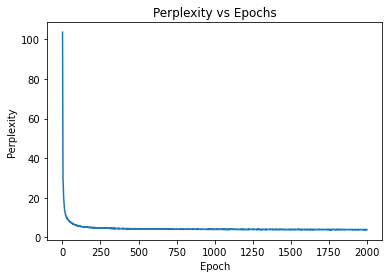

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel("Epoch")
ax.set_ylabel("Perplexity")

ax.set_title("Perplexity vs Epochs")

ax.plot(range(1,epochs+1), perplexities, label="Perplexity")

In [29]:
import random
import string

def get_random_string(length):
    result_str = ''.join(random.choice(string.ascii_letters + string.digits + ' ') for i in range(length))

    return result_str


ranstr = get_random_string(5)
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')
ranstr = get_random_string(5)
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')
ranstr = get_random_string(5)
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')

ztgAK 
 ztgAKn as it since any to know
When it is done much me arms.

PETRUCHIO:
The month as he cannot restrain  

xQKzm 
 xQKzmen shall prove
Rest this durreal that he such seat, and done you
I goess away
Thou shalt be entray i 

xMHzw 
 xMHzwear the fair sirnected
Live all their common that farewell: and I would he would
And then from the c 



In [30]:
ranstr = 'The'
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')
ranstr = 'What is'
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')
ranstr = 'Shall I give'
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')
ranstr = 'X087hNYB BHN BYFVuhsdbs'
print(ranstr, '\n', generate(decoder.to(device), ranstr, 100), '\n')

The 
 The sunners thy mother to make you and shack
Because upon me and seems your sucks, and I may risonus,
T 

What is 
 What is and corret?

FRIAR LAURENCE:
Thy hieved from heavetry seen for my wrong;
Let me a rumiss in find by 

Shall I give 
 Shall I give me then that you have there I be
reast now the lets than but the sunsome again:
I should strike me  

X087hNYB BHN BYFVuhsdbs 
 X087hNYB BHN BYFVuhsdbs
And till you devil in the captain an ear:
Take thee gentleman discommbed raped.

LEONTES:
And more  

